# Demonstration of downsampling hematopoietic biosamples to only unique cellular conditions
Based on 733 sample x 3.5+ million DHS presence/absence matrix

# 1. Import libraries & load datasets

In [2]:
from platform import python_version
print(python_version())

3.6.4


In [3]:
import sys
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, non_negative_factorization

In [4]:
sys.path.append('..')
import OONMFhelpers
import OONMF

#### Fetch the 733-biosample presence/absence Index
This will take at least a few minutes.
These data can be obtained from here: https://doi.org/10.5281/zenodo.3752359

In [14]:
A = pd.read_table('../data/dat_bin_FDR01_hg38.txt.gz', header=None).T
A.shape

(733, 3591898)

#### Load in biosample metadata

In [15]:
metadata = pd.read_csv('../data/replicate_metadata_733biosamples.tsv', sep='\t')
#metadata.columns
metadata.shape

(733, 5)

#### Show distribution of biosamples across "organ systems"

In [16]:
pd.crosstab(index=metadata["system"], columns="count")

col_0,count
system,
Cardiovascular,54
Connective,91
Digestive,60
Embryonic,26
Endocrine,9
Epithelial,23
Fetal Life Support,21
Genitourinary,14
Hematopoietic,109


#### Obtain subset that removes non-unique hematopoietic biosamples (668 out of 733 biosamples)

In [18]:
hemo_uniq_cut = ((metadata['system'] != "Hematopoietic") | ((metadata['system'] == "Hematopoietic") & metadata['Unique.cellular.condition'].values.astype(bool)))
sum(hemo_uniq_cut)

668

#### Subset full dataset based on the subset of unique cellular conditions

In [19]:
A_hemo_uniq = A[hemo_uniq_cut]
A_hemo_uniq.shape

(668, 3591898)

# 2. Perform the decomposition using NMF

#### Number of desired components (k) and a random seed

In [21]:
Nc = 16
seed = 20 # (not very important for NNDSVD)

#### Perform NMF with NNDSVD. Requires lots of memory and quite a bit of time
(apologies for the lack of quantification here, YMMV)

In [23]:
a = OONMF.NMFobject(theNcomps=Nc)
a.performNMF(data=A_hemo_uniq, randomseed=seed, theinit='nndsvd')

starting NMF at  20200416_00:12:54
done with NMF at  20200416_00:28:58
returning reconstruction error


5543.789302110906

#### Write the output to disk

In [24]:
a.writeNMF(Basis_foutname= '../data/2020-04-15NC16_NNDSVD_hemoUniqOnly_Basis.npy', Mixture_foutname='../data/2020-04-15NC16_NNDSVD_hemoUniqOnly_Mixture.npy')

# 3. Compare result with full dataset
Compare obtained DHS majority components to those obtained using the full 733 biosample dataset

In [25]:
original_decomp = OONMF.NMFobject(16)
original_decomp.matrix_input_name('../data/2018-06-08NC16_NNDSVD_Basis.npy', '../data/2018-06-08NC16_NNDSVD_Mixture.npy')
original_decomp.read_matrix_input(compressed=True)

#### Map components between the two models, to enable comparisons

In [99]:
tab_biosamples = pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(a.Basis, axis=1))
tab_biosamples

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
row_0,,,,,,,,,,,,,,,,
0,85,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,0,101,0,3,0,0,0,0,0,0,0,0,0,0,1,2
2,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,12
4,4,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,23,0,0,0,0,0,0,0,1,3
6,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0


In [119]:
np.argmax(tab_biosamples.values, axis=1)

array([ 0,  1,  4,  3,  2,  6,  5,  7,  8, 10,  9, 11, 12, 13,  2, 14])

So comp0 maps to comp0, comp1 to comp1, comp4 to comp2, comp3 to comp3, etcetera.

In [137]:
mapping = [0,  1,  4,  3,  2,  6,  5,  7,  8, 10,  9, 11, 12, 13,  15, 14] # switch out 2-->15
newBasis = a.Basis[:,mapping]
newMixture = a.Mixture[mapping]
pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(newBasis, axis=1), margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,85,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,87
1,0,101,0,3,0,0,0,0,0,0,0,0,0,0,2,1,107
2,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,33
3,0,0,0,21,0,0,0,0,0,0,0,0,0,0,12,0,33
4,4,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,28
5,0,0,0,0,0,23,0,0,0,0,0,0,0,0,3,1,27
6,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,18
7,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,49
8,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,27


#### Fraction of (downsampled) biosamples that remains annotated with a single strong component (not really)

In [138]:
sum(np.diag(pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(newBasis, axis=1)))) / sum(hemo_uniq_cut)
sum(np.max(tab_biosamples.values, axis=1)) / sum(hemo_uniq_cut)

0.9311377245508982

In [139]:
majcomp = np.argmax(original_decomp.Mixture, axis=0)
len(majcomp)

3591898

In [140]:
majcomp_uniq = np.argmax(newMixture, axis=0)
len(majcomp_uniq)

3591898

In [141]:
pd.crosstab(majcomp, majcomp_uniq, margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,146622,2334,38,374,4849,39,199,1120,87,129,211,234,823,455,102,54,157670
1,86,47081,0,1242,540,0,24,2,11,9,95,12,88,138,6858,0,56186
2,5655,825,485790,5240,54545,2514,7628,32323,2846,7251,1144,11178,4083,2131,2013,1375,626541
3,802,3391,298,252117,10206,6830,3568,1218,1727,1259,1164,1775,1019,4954,113115,1440,404883
4,37128,180,851,1460,231586,463,1111,1563,317,819,205,1235,1032,577,797,868,280192
5,78,1643,4,1702,5802,114776,1122,110,220,206,111,97,1022,1413,15488,293,144087
6,1,0,0,1250,1539,0,261662,0,0,1,0,0,56,128,343,0,264980
7,174,102,0,3541,8097,69,794,442811,588,1230,516,470,688,1318,1080,0,461478
8,60,7,0,1223,1078,4,350,1,114910,66,104,7,298,543,218,0,118869


In [152]:
xtab_orig = pd.crosstab(metadata["system"][hemo_uniq_cut], columns=np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), margins=False)
xtab_orig

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
system,,,,,,,,,,,,,,,,
Cardiovascular,3,4,3,1,0,0,0,0,26,0,0,0,0,17,0,0
Connective,0,64,0,25,0,0,0,0,0,0,0,0,0,0,0,2
Digestive,14,4,0,0,0,0,0,0,0,0,0,2,34,0,0,6
Embryonic,1,0,23,0,0,0,0,2,0,0,0,0,0,0,0,0
Endocrine,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
Epithelial,0,7,0,3,0,0,0,0,0,0,0,0,0,0,0,13
Fetal Life Support,0,0,0,0,0,0,18,0,1,1,0,0,0,1,0,0
Genitourinary,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
Hematopoietic,1,0,1,0,28,0,0,0,0,0,0,0,0,0,14,0


In [153]:
xtab_uniq = pd.crosstab(metadata["system"][hemo_uniq_cut], columns=np.argmax(newBasis, axis=1), margins=False)
xtab_uniq

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
system,,,,,,,,,,,,,,,,
Cardiovascular,3,4,3,1,0,0,0,0,26,0,0,0,0,17,0,0
Connective,0,60,0,17,0,0,0,0,0,0,0,0,0,0,11,3
Digestive,14,3,0,1,0,0,0,0,0,0,0,2,30,0,0,10
Embryonic,0,0,24,0,0,0,0,2,0,0,0,0,0,0,0,0
Endocrine,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
Epithelial,0,7,0,3,0,0,0,0,0,0,0,0,0,0,0,13
Fetal Life Support,0,0,0,0,0,0,18,0,1,1,0,0,0,1,0,0
Genitourinary,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
Hematopoietic,5,0,2,0,37,0,0,0,0,0,0,0,0,0,0,0


In [154]:
xtab_orig - xtab_uniq

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
system,,,,,,,,,,,,,,,,
Cardiovascular,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Connective,0,4,0,8,0,0,0,0,0,0,0,0,0,0,-11,-1
Digestive,0,1,0,-1,0,0,0,0,0,0,0,0,4,0,0,-4
Embryonic,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0
Endocrine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Epithelial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fetal Life Support,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Genitourinary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hematopoietic,-4,0,-1,0,-9,0,0,0,0,0,0,0,0,0,14,0


In [160]:
np.sum(abs(xtab_orig - xtab_uniq), axis=1)

system
Cardiovascular         0
Connective            24
Digestive             10
Embryonic              2
Endocrine              0
Epithelial             0
Fetal Life Support     0
Genitourinary          0
Hematopoietic         28
Hepatic                0
Integumentary          8
Musculoskeletal        4
Nervous               12
Renal                 16
Respiratory            0
dtype: int64

In [34]:
tab_biosamples = pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(a.Basis, axis=1), margins=True)
tab_biosamples

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,85,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,87
1,0,101,0,3,0,0,0,0,0,0,0,0,0,0,1,2,107
2,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,33
3,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,12,33
4,4,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,28
5,0,0,0,0,0,0,23,0,0,0,0,0,0,0,1,3,27
6,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,18
7,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,49
8,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,27


In [35]:
round(tab_biosamples.div(tab_biosamples["All"], axis=0)*100).astype(int)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,98,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,100
1,0,94,0,3,0,0,0,0,0,0,0,0,0,0,1,2,100
2,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,100
3,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,36,100
4,14,0,86,0,0,0,0,0,0,0,0,0,0,0,0,0,100
5,0,0,0,0,0,0,85,0,0,0,0,0,0,0,4,11,100
6,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,100
7,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,100
8,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,100


In [36]:
round(tab_biosamples.T.div(tab_biosamples.T["All"], axis=0)*100).astype(int).T

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,87,0,0,0,3,0,4,0,0,0,0,0,0,0,0,0,13
1,0,100,0,12,0,0,0,0,0,0,0,0,0,0,2,12,16
2,0,0,0,0,89,0,0,0,0,0,0,0,0,0,0,0,5
3,0,0,0,88,0,0,0,0,0,0,0,0,0,0,0,71,5
4,4,0,65,0,0,0,0,0,0,0,0,0,0,0,0,0,4
5,0,0,0,0,0,0,96,0,0,0,0,0,0,0,2,18,4
6,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,3
7,0,0,0,0,0,0,0,98,0,0,0,0,0,0,0,0,7
8,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,4


In [38]:
Comp_colors = ['#FFE500', '#FE8102', '#FF0000', '#07AF00', '#4C7D14', '#414613', '#05C1D9', '#0467FD', '#009588', '#BB2DD4', '#7A00FF', '#4A6876', '#08245B', '#B9461D', '#692108', '#C3C3C3']
neworder = np.array([16,10,7,11,2,12,1,8,4,15,14,5,9,6,3,13]).astype(int) - 1
Comp_colors = np.array(Comp_colors)[neworder]

In [167]:
import umap
reducer = umap.UMAP(min_dist=0.5, n_neighbors=200, random_state=33)
embedding = reducer.fit_transform(original_decomp.Basis[hemo_uniq_cut])
majcomp = np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1)

<Figure size 432x288 with 0 Axes>

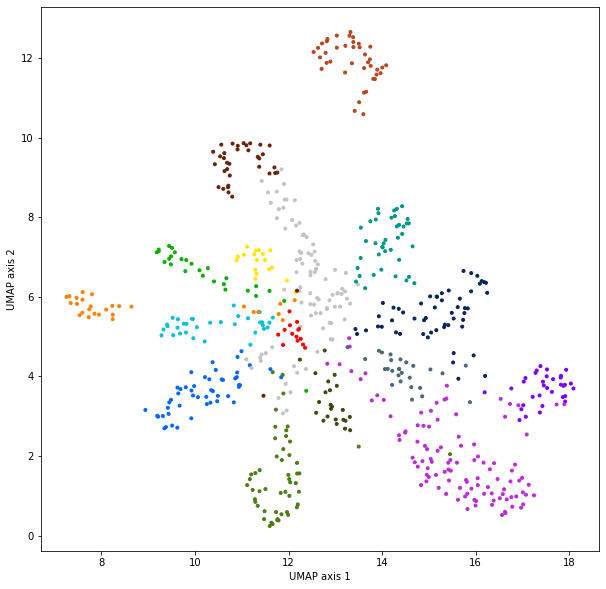

In [168]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], color=Comp_colors[majcomp], alpha=1, marker='.')
plt.ylabel('UMAP axis 2')
plt.xlabel('UMAP axis 1')
plt.show()

In [175]:
import umap
reducer = umap.UMAP(min_dist=0.5, n_neighbors=200, random_state=33)
embedding = reducer.fit_transform(newBasis)
#majcomp = np.argmax(newBasis, axis=1)

<Figure size 432x288 with 0 Axes>

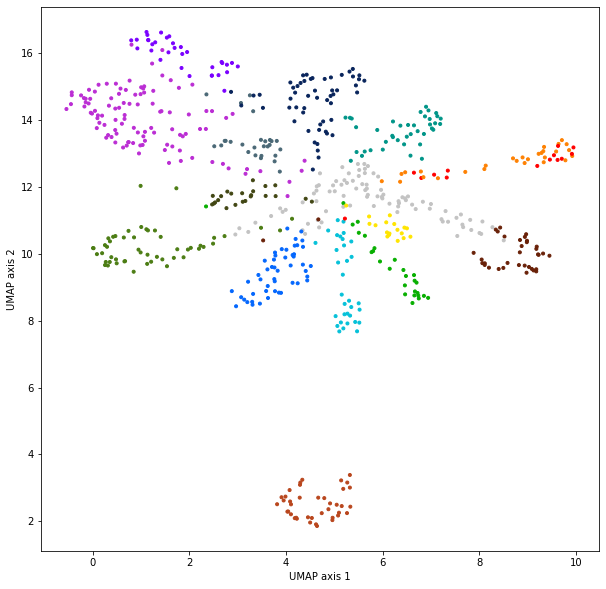

In [176]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], color=Comp_colors[majcomp], alpha=1, marker='.')
plt.ylabel('UMAP axis 2')
plt.xlabel('UMAP axis 1')
plt.show()

In [184]:
df = pd.DataFrame(data=newBasis)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.789250,0.000000,0.774958,0.0,0.392181,0.156598,0.176739,0.0,0.06129,0.112327,0.0,0.0,2.734956,0.328795,0.0,0.000000
1,0.609867,0.085530,0.000000,0.0,3.310334,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,0.062205,1.393273,0.000000,0.0,0.000000,0.000000,0.142447,0.0,0.00000,0.000000,0.0,0.0,0.383558,0.104290,0.0,2.647451
3,0.959144,0.000000,0.332001,0.0,0.023422,0.000000,0.127856,0.0,0.00000,0.000000,0.0,0.0,0.833716,0.000000,0.0,0.000000
4,1.008911,0.000000,0.291929,0.0,0.000000,0.000000,0.230967,0.0,0.00000,0.000000,0.0,0.0,1.452392,0.000000,0.0,0.000000


In [ ]:
df[8].rank(ascending=False).sort.head(10)

In [199]:
metadata[hemo_uniq_cut][533:534]

,DS_plus,repls,DCC.SPOT1,system,Unique.cellular.condition
587,DS24731A,NaN,0.4953,Cardiovascular,1


In [212]:
a.writeNMF_CSV(Basis_foutname= '../data/2020-04-15NC16_NNDSVD_hemoUniqOnly_Basis.tsv', Mixture_foutname='../data/2020-04-15NC16_NNDSVD_hemoUniqOnly_Mixture.tsv')